# **HANDS-ON: SPEECH-TO-TEXT RECOGNITION WITH NEURAL NETWORKS**


In [1]:
import os
import numpy as np
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display


# Att-HACK: A dataset of expressive speech


**Download the dataset**

In [44]:
from scipy.io import wavfile
import pandas as pd
from tqdm import tqdm

wavs_path = '/content/Dataset'
DATA = pd.read_csv('/content/DATA.csv')
wavs = os.listdir(wavs_path)
print('len wavs:', len(wavs))

data = []

for i in tqdm(range(len(DATA))):
  wav = DATA.iloc[i]['wav']
  txt = DATA.iloc[i]['txt']
  
  data.append({'audio': wavs_path + '/' + wav, 'text': txt}) 
random.shuffle(data)

len wavs: 552


100%|██████████| 552/552 [00:00<00:00, 3157.31it/s]


**Sample in Dataset**

text: nous allons prendre notre journée


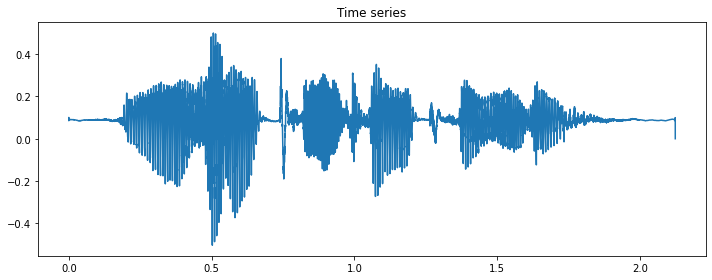

In [47]:
from IPython.display import Audio 
from IPython.core.display import display

sample = random.sample(data, 1)[0]

y, sr = librosa.load(sample['audio'])

plt.figure(figsize=(10, 4))
plt.title('Time series')
# define time axis
t = [float(i)/sr for i, _ in enumerate(y)]
plt.plot(t, y)
plt.tight_layout()

display(Audio(sample['audio'], autoplay=True))

print('text:', sample['text'])



**Speech signal representation**

**Analysis Parameters**

In [48]:
params = {'frame_length' : 512, 
          'frame_step'  : 256, 
          'fft_length' : 1024,
          'n_mel' : 80,
          'min_freq' : 125,
          'max_freq' : 8000}

**Short-Term-Fourier Transform (STFT) and linear spectrogram**

In [49]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

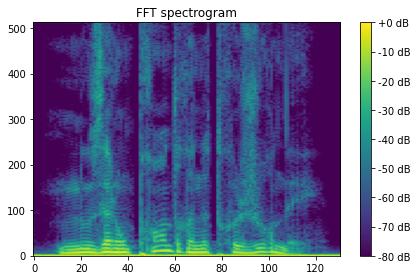

In [50]:
audio = tf.io.read_file(sample['audio'])
audio, sr = tf.audio.decode_wav(audio, 1)
audio = tf.squeeze(audio, axis=-1)
S = tf.signal.stft(audio, frame_length=params['frame_length'], frame_step=params['frame_step'], fft_length=params['fft_length'])
S = tf.abs(S)**2
S = power_to_db(S)


plt.imshow(np.transpose(S), aspect='auto', origin = 'lower')
plt.colorbar(format='%+2.0f dB')
plt.title('FFT spectrogram')
plt.tight_layout()
plt.show()

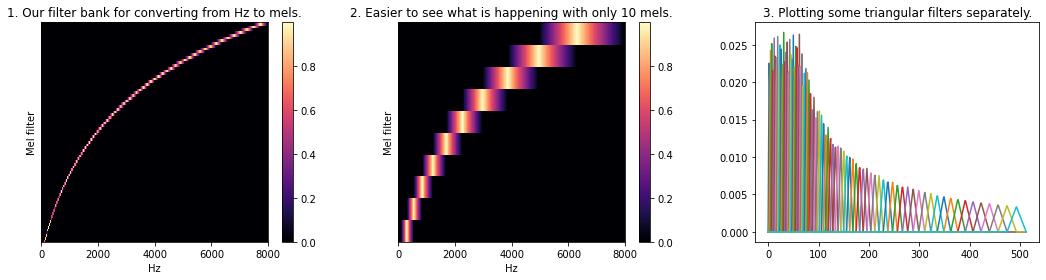

In [51]:
mel = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=params['n_mel'], 
                                            num_spectrogram_bins=S.shape[-1], 
                                            sample_rate=sr, 
                                            lower_edge_hertz=params['min_freq'],
                                            upper_edge_hertz=params['max_freq'])
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)

librosa.display.specshow(np.transpose(mel.numpy()), sr=sr, hop_length=params['frame_step'], x_axis='linear')
plt.ylabel('Mel filter')
plt.colorbar()
plt.title('1. Our filter bank for converting from Hz to mels.')

plt.subplot(1, 3, 2);
mel_10 = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=10, 
                                              num_spectrogram_bins=S.shape[-1], 
                                              sample_rate=sr, 
                                             lower_edge_hertz=params['min_freq'],
                                              upper_edge_hertz=params['max_freq'])
librosa.display.specshow(np.transpose(mel_10.numpy()), sr=sr, hop_length=params['frame_step'], x_axis='linear')
plt.ylabel('Mel filter')
plt.colorbar()
plt.title('2. Easier to see what is happening with only 10 mels.')

mel = librosa.filters.mel(sr=sr, n_fft=params['fft_length'], n_mels=80)
plt.subplot(1, 3, 3);
idxs_to_plot = range(params['n_mel'])
for i in idxs_to_plot:
    plt.plot(mel[i])
plt.title('3. Plotting some triangular filters separately.')

plt.tight_layout()

In [52]:
def get_melspec(path):

    audio = tf.io.read_file(path)
    audio, sr = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    S = tf.signal.stft(audio, frame_length=params['frame_length'], frame_step=params['frame_step'], fft_length=params['fft_length'])
    S = tf.abs(S)**2
    mel = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=params['n_mel'], 
                                            num_spectrogram_bins=S.shape[-1], 
                                            sample_rate=sr, 
                                            lower_edge_hertz=params['min_freq'],
                                            upper_edge_hertz=params['max_freq'])
    #mel = librosa.filters.mel(sr=sr, n_fft=params['fft_length'], n_mels=params['n_mel'])
    x = tf.matmul(S, mel)
    x = power_to_db(x)
    #x = tf.transpose(x)
    return x

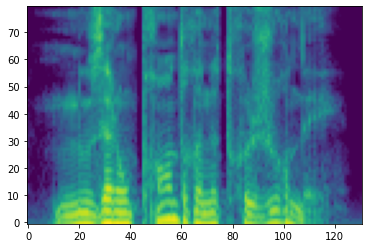

text: nous allons prendre notre journée


In [53]:
melspec = get_melspec(sample['audio'])
plt.imshow(np.transpose(melspec), aspect='auto', origin = 'lower')
plt.show()
print('text:', sample['text'])

**Preprocess the dataset**

In [54]:
class VectorizeChar:
  def __init__(self, DATA, max_len=50):
    self.vocab = ["_", "<", ">"]
    self.vocab += list(np.unique(np.concatenate([list(txt) for txt in DATA['txt']])))

    print('vocab:', self.vocab)
    self.max_len = max_len
    self.char_to_idx = {}
    for i, ch in enumerate(self.vocab):
      self.char_to_idx[ch] = i

  def __call__(self, text):
    text = text.lower()
    text = text[: self.max_len - 2]
    text = "<" + text + ">"
    pad_len = self.max_len - len(text)
    return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

  def get_vocabulary(self):
    return self.vocab


max_target_len = np.max([len(txt) for txt in DATA['txt']]) + 2
print('max target len:', max_target_len)
vectorizer = VectorizeChar(DATA, max_target_len)
print('text:', sample['text'])
print('vectorized text:', vectorizer(sample['text']))
vocab_size = len(vectorizer.get_vocabulary())
print("vocab size", vocab_size)


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def get_pad_len(path):

    wavs = os.listdir(wavs_path)
    
    lens = []
    for wav in wavs:
      x = get_melspec(path + '/' + wav)
      lens.append(x.shape[0])
    pad_len = np.max(lens)
    return pad_len


def path_to_audio(path):
    # melspectrogram
    x = get_melspec(path)
    # normalisation
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    x = (x - means) / stddevs
    audio_len = tf.shape(x)[0]
    # padding 
    pad_len = 332
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.AUTOTUNE
    )
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

#pad_len = get_pad_len(wavs_path)
#print('pad_len:', pad_len)
split = int(len(data) * 0.8)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

max target len: 35
vocab: ['_', '<', '>', ' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'è', 'é', 'ê', 'ô', 'û', '’']
text: nous allons prendre notre journée
vectorized text: [1, 19, 20, 26, 24, 3, 6, 17, 17, 20, 19, 24, 3, 21, 23, 10, 19, 9, 23, 10, 3, 19, 20, 25, 23, 10, 3, 15, 20, 26, 23, 19, 34, 10, 2]
vocab size 39


# Transformer

**Define the Transformer Input Layer**

In [55]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=1, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=1, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=1, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


**Visualization of Text Embedding**

target: <il fait beau ce soir à paris>


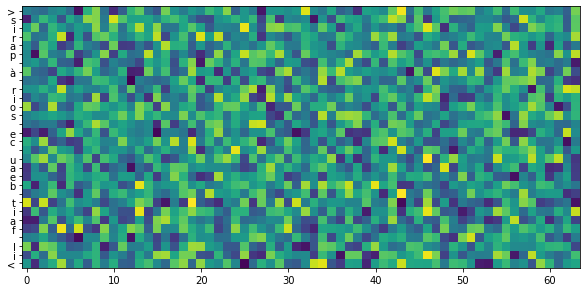

In [56]:
Txt_pre_Net = TokenEmbedding(num_vocab=vocab_size, maxlen=max_target_len, num_hid=64)

sample = random.sample(data, 1)[0]
source = np.expand_dims(path_to_audio(sample['audio']), 0)
target = '<' + sample['text'] + '>'
target_one_hot = np.expand_dims([vectorizer.get_vocabulary().index(t) for t in target], 0)

emb = Txt_pre_Net(target_one_hot)[0, :, :]
print('target:', target)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(emb, origin='lower')
ax.set_yticks(np.arange(len(target)))
ax.set_yticklabels(target)
plt.show()

**scaled dot product**

In [57]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    print('scaled_attention:', scaled_attention_logits)
    #scaled_attention_logits += (tf.cast(mask, tf.float32)  * -1e9)
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

**Multi-Head Attention Layer**

In [58]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

**Transformer Encoder Layer**

In [59]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        #self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att = MultiHeadAttention(d_model=embed_dim, num_heads=num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output, _ = self.att(v=inputs, k=inputs, q=inputs, mask=None)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

**Transformer Decoder Layer**

In [60]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        #self.self_att = MultiHeadAttention(d_model=embed_dim, num_heads=num_heads)
        #self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.enc_att = MultiHeadAttention(d_model=embed_dim, num_heads=num_heads)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        
      
        enc_out, ats_scores = self.enc_att(enc_out, enc_out, target_norm, mask=None)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return {'y': ffn_out_norm, 'ats_scores' : ats_scores}

**Complete the Transformer model**

In [61]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        ats_scores = []
        for i in range(self.num_layers_dec):
            out = getattr(self, f"dec_layer_{i}")(enc_out, y)
            y = out['y']
            ats_scores.append(out['ats_scores'])
        return {'y' : y, 'ats_scores' : ats_scores}

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        out = self.decode(x, target)
        pred = self.classifier(out['y'])
        return pred

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out['y'])
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return {'y': dec_input, 'ats_scores' : dec_out['ats_scores']}

**Callbacks to display predictions**

In [62]:
class Attention_Displayer:
  def __init__(self, vocab, path):
    self.vocab = vocab
    self.path = path
  def __call__(self, att_scores, mels, txts, epoch):
    n_layers = len(att_scores)
    n_batch = att_scores[0].shape[0]
    n_heads = att_scores[0].shape[1]

    for b in range(n_batch):
      txt = txts[b]
      if 0 in list(txt):
        txt_id = list(txt).index(0)
        txt = txt[1:txt_id]
      else:
        txt_id = len(txt)

      mel = mels[b]
      mel_id = np.where(mel[:, 0]==0.)
      
      if mel_id[0].shape[0] != 0:
        
        mel_id = mel_id[0][0]
      else:
        mel_id = mel[:, 0].shape[0]

      

      name = 'ghjk_' + str(epoch) + '_be' + str(b) 
      fig, ax = plt.subplots(n_layers, n_heads, figsize=(10, 6))
      for l in range(n_layers):
        att = att_scores[l].numpy()
        red_att = att[:, :, :txt_id, :mel_id]
        for h in range(n_heads):
          sub_att = red_att[b, h, :, :]
          
          
          if n_layers==1:
            ax[h].imshow(sub_att, origin='lower', aspect='auto', extent=[0, sub_att.shape[-1], 0, len(txt)])
            ax[h].set_yticks(np.arange(len(txt)))
            ax[h].set_yticklabels([self.vocab[i] for i in txt])
            ax[h].set_title('Head ' + str(h))
            ax[h].set_xlabel('Time frames of the input speech representation')
            ax[h].set_ylabel('Characters')
      if self.path != None:
        plt.savefig(self.path + '/' + name + '.png')
      else:
        plt.show()


In [63]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=1, target_end_token_idx=2
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token
        self.Att_Displayer = Attention_Displayer(vocab=self.idx_to_char, path=None)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 != 0:
            return
        
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        out = self.model.generate(source, self.target_start_token_idx)
        preds = out['y'].numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")
        self.Att_Displayer(out['ats_scores'], source, target, epoch)

**Learning rate schedule**

In [64]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)

**Create & train the end-to-end model**

In [65]:
model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=vocab_size,
)

In [66]:
#In case you want to train the model just use the following lines
'''
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=1, target_end_token_idx=2
) 
sw_cb = tf.keras.callbacks.ModelCheckpoint('/content/transformer_weights.h5',
    monitor="val_loss",
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)


loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)

 
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb, sw_cb], epochs=100, shuffle=True)
'''

'\nbatch = next(iter(val_ds))\n\n# The vocabulary to convert predicted indices into characters\nidx_to_char = vectorizer.get_vocabulary()\ndisplay_cb = DisplayOutputs(\n    batch, idx_to_char, target_start_token_idx=1, target_end_token_idx=2\n) \nsw_cb = tf.keras.callbacks.ModelCheckpoint(\'/content/transformer_weights.h5\',\n    monitor="val_loss",\n    verbose=2,\n    save_best_only=True,\n    save_weights_only=True,\n    mode="auto",\n    save_freq="epoch",\n)\n\n\nloss_fn = tf.keras.losses.CategoricalCrossentropy(\n    from_logits=True, label_smoothing=0.1,\n)\n\nlearning_rate = CustomSchedule(\n    init_lr=0.00001,\n    lr_after_warmup=0.001,\n    final_lr=0.00001,\n    warmup_epochs=15,\n    decay_epochs=85,\n    steps_per_epoch=len(ds),\n)\n\n \noptimizer = keras.optimizers.Adam(learning_rate)\nmodel.compile(optimizer=optimizer, loss=loss_fn)\n\nhistory = model.fit(ds, validation_data=val_ds, callbacks=[display_cb, sw_cb], epochs=100, shuffle=True)\n'

**Evaluator**

In [67]:
class eval:

  def __init__(self, model, idx_to_char, target_start_token_idx, target_end_token_idx):

    self.model = model
    self.idx_to_char = idx_to_char
    self.target_start_token_idx = target_start_token_idx
    self.target_end_token_idx = target_end_token_idx
    self.Att_Displayer = Attention_Displayer(vocab=self.idx_to_char, path=None)

  def __call__(self, source):

    out = self.model.generate(source=np.expand_dims(source, 0), target_start_token_idx=self.target_start_token_idx)
    preds = out['y'].numpy()
    target = sample['text']
    prediction = ''
    for idx in preds[0, :]:
      prediction += self.idx_to_char[idx]
      if idx == 2:
        break
  
    print('target:', target)
    print(f"prediction: {prediction[1:-1]}\n")
    target = "<" + target + ">"
    target = [self.idx_to_char.index(t) for t in target]
    self.Att_Displayer(out['ats_scores'], np.expand_dims(source, 0), np.expand_dims(target, 0), None)
  



**Load weights in the model**

In [68]:
# We first need to initialize the modelweights of the model
sample = random.sample(data, 1)[0]
source = np.expand_dims(path_to_audio(sample['audio']), 0)
target = np.expand_dims([vectorizer.get_vocabulary().index(t) for t in '<' + sample['text'] + '>'], 0)
model([source, target])
model.load_weights('/content/transformer_weights.h5')

**Evaluate on random samples**

target: je suis parti sans trainer
prediction: je suis parti sans trainer



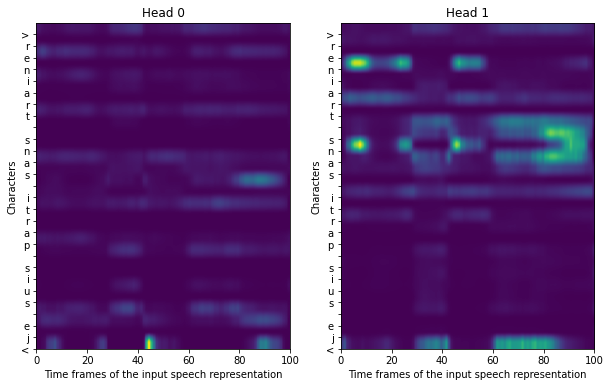

In [69]:
evaluator = eval(model=model, 
                idx_to_char=vectorizer.get_vocabulary(), 
                target_start_token_idx=1, target_end_token_idx=2)

sample = random.sample(data, 1)[0]
evaluator(source=path_to_audio(sample['audio']))